In [ ]:
# %% [markdown]
# ============================================================
# Block 0: Config - paths & evaluation settings
# ============================================================

# 说明：
# 1) RESULTS_ROOT 应该指向你这一次实验的 results_XXX 文件夹
#    例如: "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results_WTI_trading_tuned_20251201_123456"
# 2) RANKING_CSV_PATH 就是你现在这个 WTI_trading_report_rankings.csv
# 3) RAW_DATA_PATH 指向原始 WTI-log.csv（用来取 date 的参考，也可以不用）

RESULTS_ROOT = "./results_WTI_trading_tuned_20251202_175241"
RANKING_CSV_PATH = "./results_WTI_trading_tuned_20251202_175241/WTI_trading_report_rankings.csv"
RAW_DATA_PATH = "./dataset/FBD/WTI-log.csv"  # 用不到也没关系

# 使用哪个 horizon 做交易信号（true_h / pred_h）
HORIZON = 0

# 三个回测时间段
EVAL_PERIODS = [
    ("2017-01-01", "2020-01-01", "2017–2020"),
    ("2020-01-01", "2022-01-01", "2020–2022"),
    ("2022-01-01", None,         "2022–Now"),
]

# 输出 backtest 汇总结果的 CSV
OUTPUT_BACKTEST_CSV = "WTI_backtest_regimes_all_models.csv"
OUTPUT_SUMMARY_TRUE_MODELS_CSV = "WTI_backtest_true_models_summary.csv"
OUTPUT_SUMMARY_TUNING_CSV = "WTI_backtest_tuning_summary.csv"


In [2]:
# %%
# ============================================================
# Block 1: Imports & Load ranking / raw data
# ============================================================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")


def load_rankings_and_raw(rank_path: str, raw_path: str | None = None):
    """读取 ranking CSV 和可选 raw 数据。"""
    rank_df = pd.read_csv(rank_path)

    raw_df = None
    if raw_path is not None and os.path.exists(raw_path):
        raw_df = pd.read_csv(raw_path)
        if "date" in raw_df.columns:
            raw_df["date"] = pd.to_datetime(raw_df["date"])
            raw_df = raw_df.sort_values("date").reset_index(drop=True)
    return rank_df, raw_df


rank_df, raw_df = load_rankings_and_raw(RANKING_CSV_PATH, RAW_DATA_PATH)

print("Loaded rankings:", rank_df.shape)
if raw_df is not None:
    print("Loaded raw data:", raw_df.shape)


Loaded rankings: (102, 22)
Loaded raw data: (10685, 7)


In [3]:
# %%
# ============================================================
# Block 2: Map model_id -> prediction CSV path & loader
# ============================================================

def model_id_to_pred_path(model_id: str, results_root: str) -> str:
    """
    假设目录结构为:
      RESULTS_ROOT / <model_id> / data_table.csv
    """
    return os.path.join(results_root, model_id, "data_table.csv")


def load_prediction_table(model_id: str, results_root: str) -> pd.DataFrame | None:
    """读取某个 model 的预测结果 data_table.csv，如果不存在则返回 None。"""
    path = model_id_to_pred_path(model_id, results_root)
    if not os.path.exists(path):
        print(f"[WARN] data_table not found for model_id={model_id}")
        return None

    df = pd.read_csv(path)
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.sort_values("date").reset_index(drop=True)
    return df


In [4]:
# %%
# ============================================================
# Block 3: Classify models - true vs tuning & parse tuning info
# ============================================================

def classify_model(model_id: str) -> dict:
    """
    根据 model_id 字符串判断：
      - group: 'true_model' or 'tuning'
      - tuning_type: 'horizon' / 'lr' / 'dropout' / 'seqlen' / 'dmodel' / None
      - tuning_value: 数值或字符串
      - arch_name: 模型架构名 (DLinear, PatchTST, ...)
    规则参照 WTI_tuned.sh 的命名。
    """
    s = model_id.lower()

    # 架构名：从 'WTI-log_' 之后截取到下一个 '_'（大致够用）
    arch_match = re.search(r"wti-log_([^_]+)", model_id)
    arch_name = arch_match.group(1) if arch_match else "Unknown"

    info = {
        "group": None,
        "tuning_type": None,
        "tuning_value": None,
        "arch_name": arch_name,
    }

    # true models: ModelComparison
    if "modelcomparison" in s:
        info["group"] = "true_model"
        return info

    # tuning 部分
    info["group"] = "tuning"

    # 1) Horizon: ...DLinear_horizon5... / ...Horizon5_0...
    if "horizon" in s:
        info["tuning_type"] = "horizon"
        m = re.search(r"horizon(\d+)", s)
        if m:
            info["tuning_value"] = int(m.group(1))
        return info

    # 2) Learning rate: HP_lr0.0005
    if "hp_lr" in s:
        info["tuning_type"] = "lr"
        m = re.search(r"hp_lr([0-9.]+)", s)
        if m:
            info["tuning_value"] = float(m.group(1))
        return info

    # 3) Dropout: HP_dropout0.3
    if "hp_dropout" in s:
        info["tuning_type"] = "dropout"
        m = re.search(r"hp_dropout([0-9.]+)", s)
        if m:
            info["tuning_value"] = float(m.group(1))
        return info

    # 4) SeqLen: HP_seqlen128
    if "hp_seqlen" in s:
        info["tuning_type"] = "seqlen"
        m = re.search(r"hp_seqlen(\d+)", s)
        if m:
            info["tuning_value"] = int(m.group(1))
        return info

    # 5) d_model: HP_dmodel128 或 HP_DModel
    if "hp_dmodel" in s or "hp_dmodel" in s:
        info["tuning_type"] = "dmodel"
        m = re.search(r"hp_dmodel(\d+)", s)
        if m:
            info["tuning_value"] = int(m.group(1))
        return info

    # fallback：依然是 tuning，但具体类型未知
    info["tuning_type"] = "other"
    info["tuning_value"] = None
    return info


# 在 ranking 表中附加分类信息（方便调试）
rank_df["group"] = rank_df["model_id"].apply(lambda x: classify_model(x)["group"])
rank_df["tuning_type"] = rank_df["model_id"].apply(lambda x: classify_model(x)["tuning_type"])
rank_df["tuning_value"] = rank_df["model_id"].apply(lambda x: classify_model(x)["tuning_value"])
rank_df["arch_name"] = rank_df["model_id"].apply(lambda x: classify_model(x)["arch_name"])

print(rank_df[["model_id", "group", "tuning_type", "tuning_value", "arch_name"]].head(10))


                                            model_id       group tuning_type  \
0  long_term_forecast_WTI-log_Nonstationary_Trans...  true_model        None   
1  long_term_forecast_WTI-log_Nonstationary_Trans...  true_model        None   
2  long_term_forecast_WTI-log_Transformer_pl5_Tra...  true_model        None   
3  long_term_forecast_WTI-log_Transformer_pl5_Tra...  true_model        None   
4  long_term_forecast_WTI-log_Crossformer_pl5_Cro...  true_model        None   
5  long_term_forecast_WTI-log_Transformer_pl5_Tra...  true_model        None   
6  long_term_forecast_WTI-log_Nonstationary_Trans...  true_model        None   
7  long_term_forecast_WTI-log_Crossformer_pl5_Cro...  true_model        None   
8  long_term_forecast_WTI-log_Crossformer_pl5_Cro...  true_model        None   
9  long_term_forecast_WTI-log_DLinear_horizon1_DL...      tuning     horizon   

   tuning_value arch_name  
0           NaN   Unknown  
1           NaN   Unknown  
2           NaN   Unknown  
3      

In [5]:
# %%
# ============================================================
# Block 4: Backtest utilities - positions & metrics
# ============================================================

def position_from_prediction(pred: np.ndarray, threshold: float = 0.0) -> np.ndarray:
    """
    非杠杆、方向性策略：
      pred > threshold  -> 多头 +1
      pred <= threshold -> 空头 -1
    """
    return np.where(pred > threshold, 1.0, -1.0)


def compute_max_drawdown(cum_pnl: np.ndarray) -> float:
    """最大回撤（绝对数值，负数，越小越差）"""
    if len(cum_pnl) == 0:
        return np.nan
    peak = np.maximum.accumulate(cum_pnl)
    drawdown = cum_pnl - peak
    return float(drawdown.min())


def compute_perf_metrics(daily_ret: np.ndarray) -> dict:
    """
    daily_ret: 每日策略收益（可以是 PnL / 初始资本）
    返回年化收益、波动、Sharpe
    """
    res = {
        "ann_return": np.nan,
        "ann_vol": np.nan,
        "sharpe": np.nan,
    }
    if len(daily_ret) == 0:
        return res

    mean_d = daily_ret.mean()
    std_d = daily_ret.std(ddof=1) if len(daily_ret) > 1 else 0.0
    ann_ret = mean_d * 252
    ann_vol = std_d * np.sqrt(252) if std_d > 0 else np.nan
    sharpe = ann_ret / ann_vol if (ann_vol and ann_vol > 0) else np.nan

    res["ann_return"] = float(ann_ret)
    res["ann_vol"] = float(ann_vol)
    res["sharpe"] = float(sharpe)
    return res


In [6]:
# %%
# ============================================================
# Block 5: Backtest a single model_id on one period
# ============================================================

def slice_by_period(df: pd.DataFrame, start: str, end: str | None) -> pd.DataFrame:
    start_dt = pd.to_datetime(start)
    if end is not None:
        end_dt = pd.to_datetime(end)
        mask = (df["date"] >= start_dt) & (df["date"] < end_dt)
    else:
        mask = (df["date"] >= start_dt)
    return df.loc[mask].copy()


def backtest_one_model_one_period(
    model_id: str,
    pred_df: pd.DataFrame,
    start: str,
    end: str | None,
    horizon: int,
    threshold: float = 0.0,
    plot: bool = False,
) -> dict:
    """
    在 [start, end) 区间上，回测一个模型（指定 horizon）。
    使用列名 true_{horizon}, pred_{horizon}.
    """
    true_col = f"true_{horizon}"
    pred_col = f"pred_{horizon}"

    if true_col not in pred_df.columns or pred_col not in pred_df.columns:
        print(f"[WARN] {model_id}: missing {true_col} / {pred_col}, skip")
        return {}

    sub = slice_by_period(pred_df, start, end)
    sub = sub[["date", true_col, pred_col]].dropna().reset_index(drop=True)

    if sub.empty:
        print(f"[WARN] {model_id}: no data in period {start} ~ {end}")
        return {}

    true_ret = sub[true_col].values.astype(float)
    pred = sub[pred_col].values.astype(float)

    position = position_from_prediction(pred, threshold=threshold)
    strat_daily = position * true_ret
    bh_daily = true_ret.copy()

    strat_cum = strat_daily.cumsum()
    bh_cum = bh_daily.cumsum()

    strat_metrics = compute_perf_metrics(strat_daily)
    bh_metrics = compute_perf_metrics(bh_daily)

    hit_ratio = float((strat_daily > 0).mean())
    max_dd = compute_max_drawdown(strat_cum)
    n_days = int(len(sub))

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(sub["date"], strat_cum, label="Strategy")
        plt.plot(sub["date"], bh_cum, label="Buy & Hold", linestyle="--")
        plt.title(f"{model_id}\n{start} ~ {end or 'End'} | horizon={horizon}")
        plt.xlabel("Date")
        plt.ylabel("Cumulative PnL (1 lot)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        "n_days": n_days,
        "hit_ratio": hit_ratio,
        "strat_ann_return": strat_metrics["ann_return"],
        "strat_ann_vol": strat_metrics["ann_vol"],
        "strat_sharpe": strat_metrics["sharpe"],
        "bh_ann_return": bh_metrics["ann_return"],
        "bh_ann_vol": bh_metrics["ann_vol"],
        "bh_sharpe": bh_metrics["sharpe"],
        "strat_max_drawdown": max_dd,
    }


In [7]:
# %%
# ============================================================
# Block 6: Run backtests for all models & periods
# ============================================================

all_rows = []

for idx, row in rank_df.iterrows():
    model_id = row["model_id"]
    cls = classify_model(model_id)
    group = cls["group"]
    tuning_type = cls["tuning_type"]
    tuning_value = cls["tuning_value"]
    arch_name = cls["arch_name"]

    pred_df = load_prediction_table(model_id, RESULTS_ROOT)
    if pred_df is None:
        continue

    for start, end, label in EVAL_PERIODS:
        bt_res = backtest_one_model_one_period(
            model_id=model_id,
            pred_df=pred_df,
            start=start,
            end=end,
            horizon=HORIZON,
            threshold=0.0,
            plot=False,  # 如果想看曲线可以设成 True
        )
        if not bt_res:
            continue

        row_out = {
            "model_id": model_id,
            "arch_name": arch_name,
            "group": group,
            "tuning_type": tuning_type,
            "tuning_value": tuning_value,
            "period_label": label,
            "period_start": start,
            "period_end": end,
        }
        row_out.update(bt_res)
        all_rows.append(row_out)

bt_df = pd.DataFrame(all_rows)
print("Backtest rows:", bt_df.shape)
print(bt_df.head())

# 保存完整回测结果
bt_df.to_csv(OUTPUT_BACKTEST_CSV, index=False)
print(f"Saved full regime backtests to {OUTPUT_BACKTEST_CSV}")


Backtest rows: (306, 17)
                                            model_id arch_name       group  \
0  long_term_forecast_WTI-log_Nonstationary_Trans...   Unknown  true_model   
1  long_term_forecast_WTI-log_Nonstationary_Trans...   Unknown  true_model   
2  long_term_forecast_WTI-log_Nonstationary_Trans...   Unknown  true_model   
3  long_term_forecast_WTI-log_Nonstationary_Trans...   Unknown  true_model   
4  long_term_forecast_WTI-log_Nonstationary_Trans...   Unknown  true_model   

  tuning_type  tuning_value period_label period_start  period_end  n_days  \
0        None           NaN    2017–2020   2017-01-01  2020-01-01     675   
1        None           NaN    2020–2022   2020-01-01  2022-01-01     503   
2        None           NaN     2022–Now   2022-01-01        None     955   
3        None           NaN    2017–2020   2017-01-01  2020-01-01     675   
4        None           NaN    2020–2022   2020-01-01  2022-01-01     503   

   hit_ratio  strat_ann_return  strat_ann_v

In [8]:
# %%
# ============================================================
# Block 7: Summarize true models (architecture comparison)
# ============================================================

if not bt_df.empty:
    tmp = bt_df.copy()

    # 去掉 seed 编号：..._ModelComparison_0/1/2 等
    tmp["base_key"] = tmp["model_id"].str.replace(r"_\d+$", "", regex=True)

    true_df = tmp[tmp["group"] == "true_model"].copy()

    # 1) 按 base_key + period 求每个 period 的平均 Sharpe
    grp_period = (
        true_df
        .groupby(["base_key", "arch_name", "period_label"], as_index=False)
        .agg(
            mean_sharpe=("strat_sharpe", "mean"),
            mean_ann_return=("strat_ann_return", "mean"),
            mean_hit_ratio=("hit_ratio", "mean"),
        )
    )

    # 2) 整体平均 Sharpe（跨 period）
    grp_overall = (
        grp_period
        .groupby(["base_key", "arch_name"], as_index=False)
        .agg(
            overall_mean_sharpe=("mean_sharpe", "mean"),
            overall_mean_ann_return=("mean_ann_return", "mean"),
            overall_mean_hit_ratio=("mean_hit_ratio", "mean"),
        )
        .sort_values("overall_mean_sharpe", ascending=False)
    )

    print("\n=== True models: overall architecture ranking (by mean Sharpe across periods) ===")
    print(grp_overall.head(20).to_string(index=False))

    # 保存
    grp_overall.to_csv(OUTPUT_SUMMARY_TRUE_MODELS_CSV, index=False)
    print(f"Saved true-model summary to {OUTPUT_SUMMARY_TRUE_MODELS_CSV}")



=== True models: overall architecture ranking (by mean Sharpe across periods) ===
                                                                                                                                                                            base_key arch_name  overall_mean_sharpe  overall_mean_ann_return  overall_mean_hit_ratio
long_term_forecast_WTI-log_Nonstationary_Transformer_pl5_Nonstationary_Transformer_custom_ftMS_sl512_ll48_pl5_dm128_nh4_el2_dl1_df128_expand2_dc4_fc3_ebtimeF_dtTrue_ModelComparison   Unknown             0.480232                 0.238633                0.522469
                             long_term_forecast_WTI-log_Transformer_pl5_Transformer_custom_ftMS_sl512_ll48_pl5_dm64_nh4_el2_dl1_df128_expand2_dc4_fc3_ebtimeF_dtTrue_ModelComparison   Unknown             0.347914                 0.125690                0.539138
                                   long_term_forecast_WTI-log_TSMixer_pl5_TSMixer_custom_ftMS_sl512_ll48_pl5_dm512_nh8_el2_dl1_df2048_

In [9]:
# %%
# ============================================================
# Block 8: Summarize tuning models (best hyperparameters)
# ============================================================

tuning_summary_rows = []

tuning_df = bt_df[bt_df["group"] == "tuning"].copy()

if not tuning_df.empty:
    tuning_types = sorted(tuning_df["tuning_type"].dropna().unique())
    print("\nTuning types found:", tuning_types)

    for t_type in tuning_types:
        sub = tuning_df[tuning_df["tuning_type"] == t_type].copy()
        if sub.empty:
            continue

        # 同样去除 seed 编号
        sub["base_key"] = sub["model_id"].str.replace(r"_\d+$", "", regex=True)

        grp = (
            sub.groupby(["tuning_type", "tuning_value"], as_index=False)
            .agg(
                mean_sharpe=("strat_sharpe", "mean"),
                mean_ann_return=("strat_ann_return", "mean"),
                mean_hit_ratio=("hit_ratio", "mean"),
            )
            .sort_values("mean_sharpe", ascending=False)
        )

        print(f"\n=== Best parameters for tuning_type = {t_type} (by mean Sharpe) ===")
        print(grp.to_string(index=False))

        tuning_summary_rows.append(grp)

    if tuning_summary_rows:
        tuning_summary_df = pd.concat(tuning_summary_rows, ignore_index=True)
        tuning_summary_df.to_csv(OUTPUT_SUMMARY_TUNING_CSV, index=False)
        print(f"\nSaved tuning summary to {OUTPUT_SUMMARY_TUNING_CSV}")



Tuning types found: ['dmodel', 'dropout', 'horizon', 'lr', 'seqlen']

=== Best parameters for tuning_type = dmodel (by mean Sharpe) ===
tuning_type  tuning_value  mean_sharpe  mean_ann_return  mean_hit_ratio
     dmodel          32.0     0.239697         0.115188        0.525163
     dmodel          64.0     0.101995         0.088339        0.510844
     dmodel         128.0    -0.180465        -0.051683        0.512114
     dmodel         256.0    -0.361191        -0.162003        0.486217

=== Best parameters for tuning_type = dropout (by mean Sharpe) ===
tuning_type  tuning_value  mean_sharpe  mean_ann_return  mean_hit_ratio
    dropout           0.2     0.284914         0.117301        0.519972
    dropout           0.3     0.101995         0.088339        0.510844
    dropout           0.4     0.016826         0.022437        0.518704
    dropout           0.1    -0.141048        -0.122673        0.514396
    dropout           0.5    -0.219222        -0.083069        0.509473

==

In [10]:
# %%
# ============================================================
# Block 9: Helper – get timeseries for plotting
# ============================================================

def compute_timeseries_for_model_period(
    pred_df: pd.DataFrame,
    start: str,
    end: str | None,
    horizon: int,
    threshold: float = 0.0,
) -> pd.DataFrame:
    """
    返回某个模型在 [start, end) 区间上的时间序列：
      date, true_ret, pred, position, strat_daily, bh_daily, strat_cum, bh_cum
    用于画曲线。
    """
    true_col = f"true_{horizon}"
    pred_col = f"pred_{horizon}"

    if true_col not in pred_df.columns or pred_col not in pred_df.columns:
        return pd.DataFrame()

    sub = slice_by_period(pred_df, start, end)
    sub = sub[["date", true_col, pred_col]].dropna().reset_index(drop=True)
    if sub.empty:
        return pd.DataFrame()

    sub = sub.rename(columns={true_col: "true_ret", pred_col: "pred"})
    sub["position"] = position_from_prediction(sub["pred"].values, threshold=threshold)
    sub["strat_daily"] = sub["position"] * sub["true_ret"]
    sub["bh_daily"] = sub["true_ret"]
    sub["strat_cum"] = sub["strat_daily"].cumsum()
    sub["bh_cum"] = sub["bh_daily"].cumsum()
    return sub


Tuning types found: ['dmodel', 'dropout', 'horizon', 'lr', 'seqlen']

=== Plotting tuning for type: dmodel ===


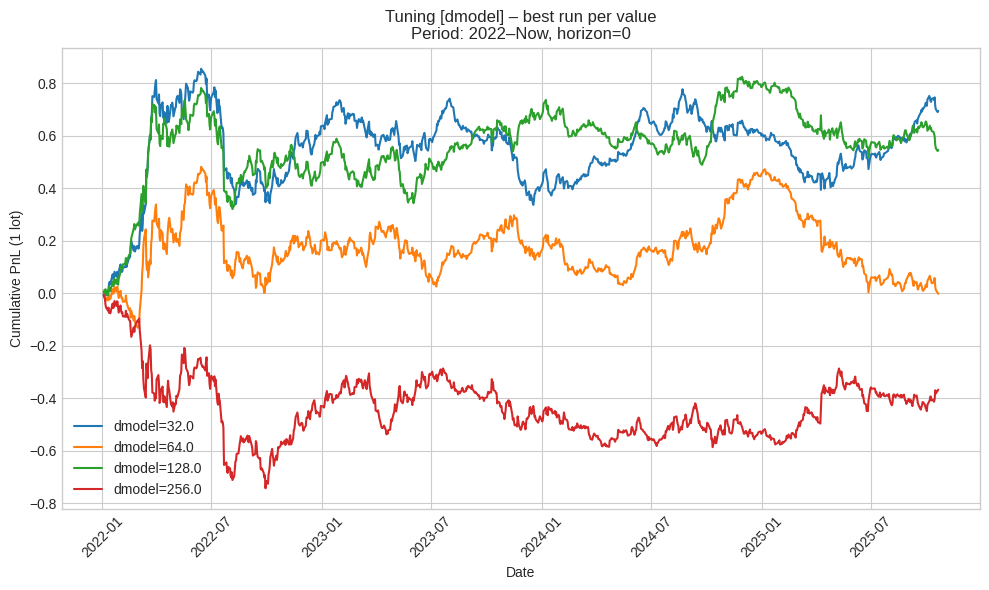


=== Plotting tuning for type: dropout ===


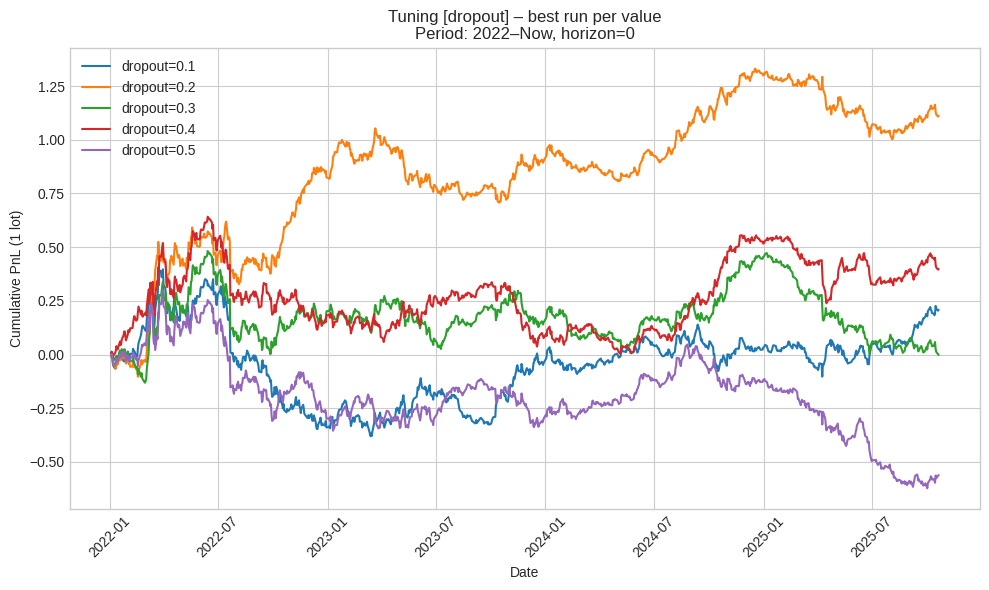


=== Plotting tuning for type: horizon ===


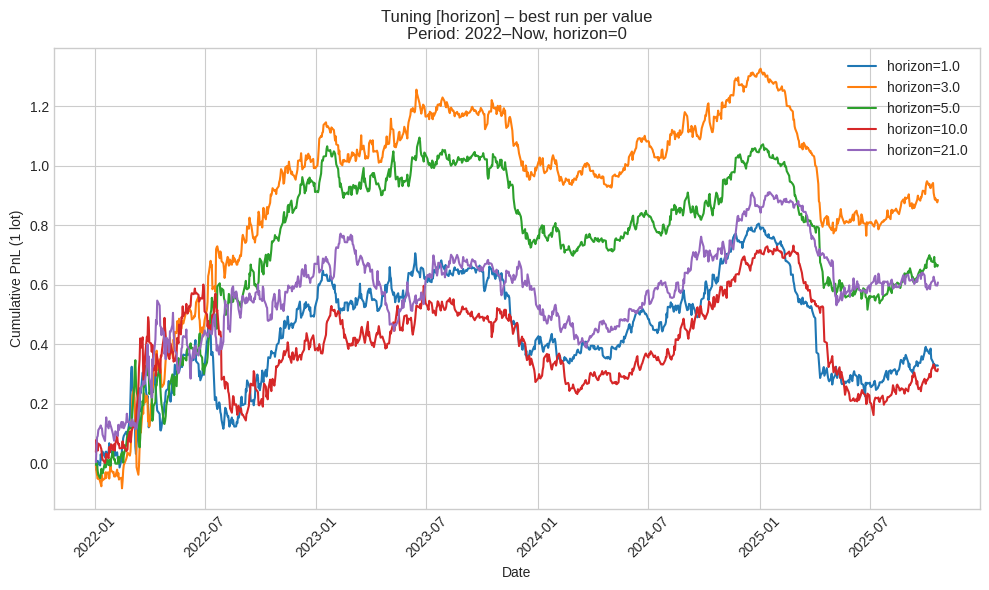


=== Plotting tuning for type: lr ===


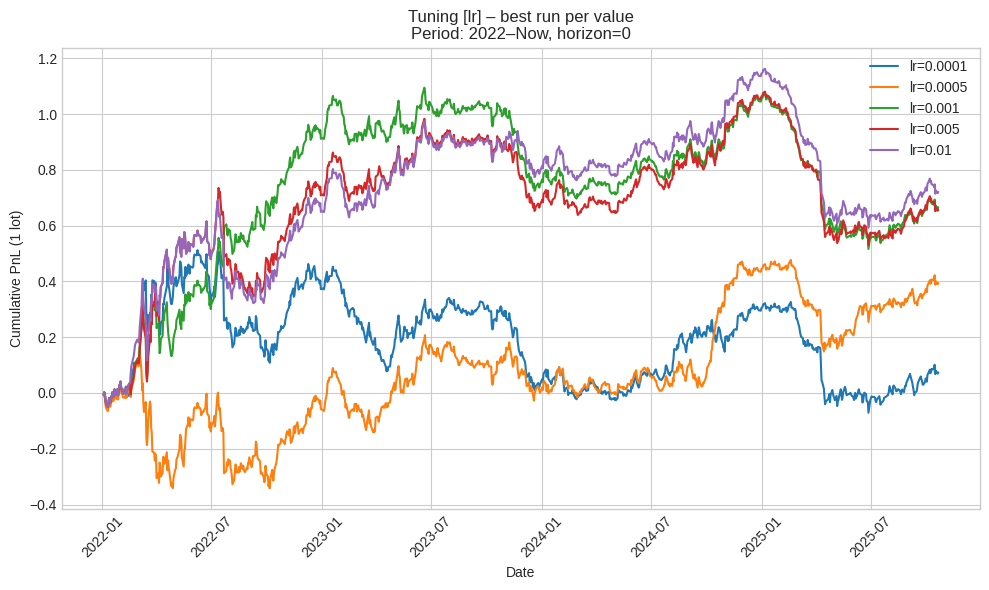


=== Plotting tuning for type: seqlen ===


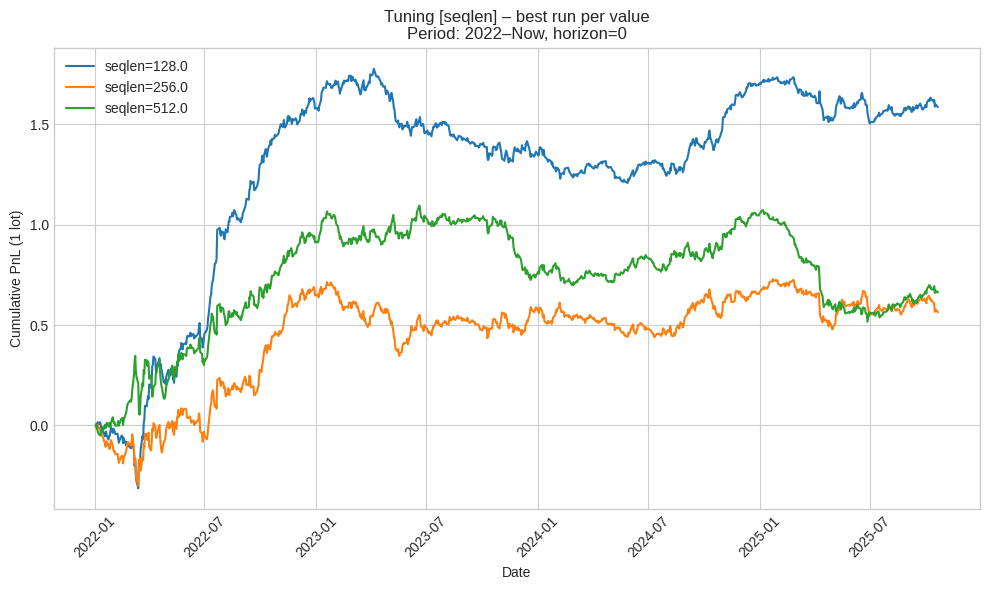

In [13]:
# %%
# ============================================================
# Block 11: Plot tuning models – one big figure per parameter
# ============================================================

# 默认只看某一个 regime（例如最近的 2022–Now）
TUNING_PLOT_PERIOD_LABEL = "2022–Now"  # 你可以改成 "2017–2020" 或 "2020–2022"


def plot_tuning_for_type(
    bt_df: pd.DataFrame,
    results_root: str,
    tuning_type: str,
    horizon: int,
    period_label: str = TUNING_PLOT_PERIOD_LABEL,
):
    """
    对某个 tuning_type（如 'lr', 'dropout', 'horizon'）画一张图：
      - 只看指定 period_label
      - 每个 tuning_value 一条最优曲线（Sharpe 最高的那条 run）
    """
    sub_summary = bt_df[
        (bt_df["group"] == "tuning")
        & (bt_df["tuning_type"] == tuning_type)
        & (bt_df["period_label"] == period_label)
    ].copy()

    if sub_summary.empty:
        print(f"No tuning data for type={tuning_type} in period={period_label}")
        return

    # 对于每个 tuning_value，取 Sharpe 最高的那条 run
    sub_summary = sub_summary.sort_values("strat_sharpe", ascending=False)
    best_rows = (
        sub_summary.groupby("tuning_value", as_index=False)
        .first()
    )

    plt.figure(figsize=(10, 6))

    for _, r in best_rows.iterrows():
        tuning_value = r["tuning_value"]
        model_id = r["model_id"]
        start = r["period_start"]
        end = r["period_end"]

        pred_df = load_prediction_table(model_id, results_root)
        if pred_df is None:
            continue

        ts = compute_timeseries_for_model_period(
            pred_df,
            start=start,
            end=end,
            horizon=horizon,
            threshold=0.0,
        )
        if ts.empty:
            continue

        label = f"{tuning_type}={tuning_value}"
        plt.plot(ts["date"], ts["strat_cum"], label=label)

    plt.title(
        f"Tuning [{tuning_type}] – best run per value\nPeriod: {period_label}, horizon={horizon}"
    )
    plt.xlabel("Date")
    plt.ylabel("Cumulative PnL (1 lot)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_all_tuning_types(bt_df: pd.DataFrame, results_root: str, horizon: int):
    tuning_df = bt_df[bt_df["group"] == "tuning"].copy()
    if tuning_df.empty:
        print("No tuning models to plot.")
        return

    tuning_types = sorted(tuning_df["tuning_type"].dropna().unique())
    print("Tuning types found:", tuning_types)

    for t_type in tuning_types:
        if t_type in (None, "other"):
            continue
        print(f"\n=== Plotting tuning for type: {t_type} ===")
        plot_tuning_for_type(
            bt_df=bt_df,
            results_root=results_root,
            tuning_type=t_type,
            horizon=horizon,
            period_label=TUNING_PLOT_PERIOD_LABEL,
        )


# 调用：对所有 tuning_type 画图
plot_all_tuning_types(
    bt_df=bt_df,
    results_root=RESULTS_ROOT,
    horizon=HORIZON,
)


In [15]:
# %%
# ============================================================
# Block 10: Plot true models – per regime, rows=models, 3 cols=3 runs
# ============================================================

import math
import os
import re
import numpy as np  # 确保 np 可用

MAX_RUNS_PER_MODEL = 3  # 每个 model 有 3 组参数 / run

# 在 RESULTS_ROOT 下建一个专门存图的文件夹
PLOT_TRUE_DIR = os.path.join(RESULTS_ROOT, "plots_true_models")
os.makedirs(PLOT_TRUE_DIR, exist_ok=True)


def clean_model_id_for_title(model_id: str) -> str:
    """
    把前缀 'long_term_forecast_WTI-log_' 和结尾的 'ModelComparison' 去掉，
    让标题更短不重叠。
    """
    s = model_id

    # 去前缀（大小写不敏感）
    s = re.sub(r'^long_term_forecast_wti-log_', '', s, flags=re.IGNORECASE)

    # 去结尾的 _ModelComparison 或 -ModelComparison 等
    s = re.sub(r'[_-]*ModelComparison.*$', '', s, flags=re.IGNORECASE)

    return s


def infer_arch_name_from_model_id(model_id: str) -> str:
    """
    直接从 model_id 里猜架构名（Autoformer / PatchTST / DLinear / Informer 等），
    避免出现 'unknown'。
    """
    s = model_id.lower()

    # 你这次实验里大概率会出现的几个关键词，可以按需要继续加
    if "autoformer" in s:
        return "Autoformer"
    if "patchtst" in s:
        return "PatchTST"
    if "dlinear" in s:
        return "DLinear"
    if "informer" in s:
        return "Informer"
    if "timesnet" in s:
        return "TimesNet"
    if "reformer" in s:
        return "Reformer"
    if "fedformer" in s:
        return "FedFormer"
    if "tft" in s:
        return "TFT"
    if "psformer" in s:
        return "PSFormer"
    if "timemixer" in s:
        return "TimeMixer"

    # 都匹配不到，就用清洗后的短名字再截一截
    short = clean_model_id_for_title(model_id)
    # 避免太长，只取前 20 个字符
    return short[:20]


def build_true_model_runs(bt_df: pd.DataFrame) -> dict:
    """
    返回:
      base_key -> {
          'arch_name': ...,
          'model_ids': [run1_id, run2_id, ...]  # 最多 3 个，按名字排序
      }
    """
    tmp = bt_df.copy()
    tmp["base_key"] = tmp["model_id"].str.replace(r"_\d+$", "", regex=True)

    true_df = tmp[tmp["group"] == "true_model"].copy()

    mapping = {}
    for base_key, g in true_df.groupby("base_key"):
        # 用第一条 model_id 来推断架构名，避免 'unknown'
        first_model_id = g["model_id"].iloc[0]
        arch_name = infer_arch_name_from_model_id(first_model_id)

        # 取所有 model_id，排序后截取前 MAX_RUNS_PER_MODEL 个
        model_ids = sorted(g["model_id"].unique().tolist())
        model_ids = model_ids[:MAX_RUNS_PER_MODEL]

        mapping[base_key] = {
            "arch_name": arch_name,
            "model_ids": model_ids,
        }
    return mapping


def plot_true_models_per_regime(
    bt_df: pd.DataFrame,
    results_root: str,
    horizon: int,
    eval_periods: list[tuple[str, str | None, str]],
):
    model_runs = build_true_model_runs(bt_df)
    if not model_runs:
        print("No true models found to plot.")
        return

    base_keys = sorted(model_runs.keys())
    n_models = len(base_keys)

    for start, end, period_label in eval_periods:
        print(f"\n=== Plotting true models for period: {period_label} [{start} ~ {end or 'End'}] ===")

        n_rows = n_models
        n_cols = MAX_RUNS_PER_MODEL

        # 把每个子图横向拉长一些：宽度乘 7，高度稍微压扁一点
        fig, axes = plt.subplots(
            n_rows,
            n_cols,
            figsize=(7 * n_cols, 1.8 * n_rows),
            sharex=False,
            sharey=False,
        )

        # 统一处理 axes 形状
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = np.array([axes])
        elif n_cols == 1:
            axes = np.array([[ax] for ax in axes])

        for row_idx, base_key in enumerate(base_keys):
            arch_name = model_runs[base_key]["arch_name"]
            model_ids = model_runs[base_key]["model_ids"]

            for col_idx in range(n_cols):
                ax = axes[row_idx, col_idx]

                if col_idx < len(model_ids):
                    model_id = model_ids[col_idx]
                    pred_df = load_prediction_table(model_id, results_root)
                    if pred_df is None:
                        ax.set_visible(False)
                        continue

                    ts = compute_timeseries_for_model_period(
                        pred_df,
                        start=start,
                        end=end,
                        horizon=horizon,
                        threshold=0.0,
                    )
                    if ts.empty:
                        ax.set_visible(False)
                        continue

                    ax.plot(ts["date"], ts["strat_cum"], label="Strategy")
                    ax.plot(ts["date"], ts["bh_cum"], linestyle="--", label="B&H")

                    # 列标题：只写 Run1/2/3，不再放长长的 model 名
                    if row_idx == 0:
                        ax.set_title(f"Run {col_idx+1}", fontsize=10)

                    # 行标注：模型 / 架构名（每行左侧 y-label）
                    if col_idx == 0:
                        ax.set_ylabel(arch_name, fontsize=10)

                    ax.tick_params(axis="x", labelrotation=30, labelsize=8)
                else:
                    # 没有那么多 run，就隐藏多余子图
                    ax.set_visible(False)

        # 只拿第一个可见子图的 legend
        first_ax = None
        for row in axes:
            for ax in row:
                if ax.get_visible():
                    first_ax = ax
                    break
            if first_ax is not None:
                break

        if first_ax is not None:
            handles, labels = first_ax.get_legend_handles_labels()
            if handles:
                fig.legend(
                    handles,
                    labels,
                    loc="upper right",
                    bbox_to_anchor=(0.98, 0.98),
                )

        fig.suptitle(
            f"True Models – Cumulative PnL (horizon={horizon})\nPeriod: {period_label}",
            fontsize=14,
        )
        fig.tight_layout(rect=[0, 0, 0.97, 0.93])

        # 保存图片而不是 show
        safe_period_label = re.sub(r"\W+", "_", period_label)
        filename = f"true_models_h{horizon}_{safe_period_label}.png"
        save_path = os.path.join(PLOT_TRUE_DIR, filename)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        plt.close(fig)
        print(f"Saved figure to: {save_path}")


# 调用绘图：对 3 个 regimes 分别画大图（只保存不显示）
plot_true_models_per_regime(
    bt_df=bt_df,
    results_root=RESULTS_ROOT,
    horizon=HORIZON,
    eval_periods=EVAL_PERIODS,
)



=== Plotting true models for period: 2017–2020 [2017-01-01 ~ 2020-01-01] ===
Saved figure to: ./results_WTI_trading_tuned_20251202_175241/plots_true_models/true_models_h0_2017_2020.png

=== Plotting true models for period: 2020–2022 [2020-01-01 ~ 2022-01-01] ===
Saved figure to: ./results_WTI_trading_tuned_20251202_175241/plots_true_models/true_models_h0_2020_2022.png

=== Plotting true models for period: 2022–Now [2022-01-01 ~ End] ===
Saved figure to: ./results_WTI_trading_tuned_20251202_175241/plots_true_models/true_models_h0_2022_Now.png
